# CISC3024 Machine Learning Final Project
- Title: Wound Detection
- Groupmates: Huang Yanzhen DC126732, Yang Zhihan DC127992

In [1]:
# Basics
import os
import random
import cv2
import copy
import time
from itertools import product
from typing import List, Callable, Any, Union

# Pre-processing
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from PIL import Image
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd

# Model Training
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold

In [2]:
model_path = "./models"

# 1. Dataset
## 1.1 Data Retrieval

In [3]:
def get_labels(data_type: str) -> np.ndarray:
    """
    Get ground truth labels from .csv file.
    :param data_type: Type of data: Training or Testing.
    """
    df = pd.read_csv(f"./Wound/{data_type}/myData.csv", delimiter=";")
    return df.to_numpy()

In [4]:
def get_images(data_type: str,
               image_names: np.ndarray,
               augmentation: Union[Callable[[np.ndarray, Any], np.ndarray], None] = None,
               flatten=True,
               resize=True,
               **kwargs) -> np.ndarray:
    """
    Get the images from directory.
    :param data_type: Type of data: Training or Testing.
    :param image_names: Names of images from ground truth.
    :param augmentation: Augmentation function.
    :param flatten: Whether to flatten the images.
    :param kwargs: Other arguments to pass to augmentation function.
    """
    images = []
    for i_name in image_names:
        img = Image.open(os.path.join(f"./Wound/{data_type}/", i_name))
        if resize:
            img = img.resize((32, 32), Image.BICUBIC)
        img = np.array(img)
        if augmentation:
            img = augmentation(img, **kwargs)
        images.append(img.flatten() if flatten else img)

    images = np.array(images)

    return images

## 1.2 Image Augmentation

In [5]:
def add_black_edge(img: np.array, w: int = 4) -> np.array:
    """
    Image augmentation. Add an inner black edge to an image.
    :param img: Image to be processed.
    :param w: Width of the edge.
    """
    if w > min(img.shape[0:2]) // 2:
        raise ValueError("Width of the edge must be smaller than half of the shorter side of an image.")

    new_img = np.zeros_like(img)
    new_img[w:-w, w:-w, :] = img[w:-w, w:-w, :]
    return new_img

In [6]:
def stretch(img: np.ndarray, f: List[float]) -> np.ndarray:
    """
    Image augmentation. Stretch an image on the width and height side.
    :param img: Image to be augmented.
    :param f: Factor tuple. Width and Height.
    """
    fw, fh = f
    if fw < 1 or fh < 1:
        raise ValueError("Width and height factors should be greater than or equal to 1.")

    # New widths
    new_width = int(img.shape[1] * fw)
    new_height = int(img.shape[0] * fh)

    # Adjust image
    img_pil = Image.fromarray(img)
    img_resized = img_pil.resize((new_width, new_height), Image.BICUBIC)

    # Crop regions
    # Keep 32x32 size
    left = (new_width - 32) // 2
    top = (new_height - 32) // 2
    right = left + 32
    bottom = top + 32

    # Crop image
    img_cropped = img_resized.crop((left, top, right, bottom))

    # Convert to numpy array
    img_stretched = np.array(img_cropped)

    return img_stretched

# 2. Train Model
One trainig of model would result in the following structure:
```python
{
    "x": {
        "Best MSE": smallest_mse,
        "Best Fold": best_fold_idx,
        "Avg MSE": avg_mse,
        "model": ModelInstance,
    },
    "y": {
        "Best MSE": smallest_mse,
        "Best Fold": best_fold_idx,
        "Avg MSE": avg_mse,
        "model": ModelInstance,
    },
    "w": {
        "Best MSE": smallest_mse,
        "Best Fold": best_fold_idx,
        "Avg MSE": avg_mse,
        "model": ModelInstance,
    },
    "h": {
        "Best MSE": smallest_mse,
        "Best Fold": best_fold_idx,
        "Avg MSE": avg_mse,
        "model": ModelInstance,
    },
}
```
This is named as an "experiment object".

In [7]:
def train(ModelInstance, X, Y, desc: str = "DESC", n_fold: int = 3, save: bool = False):
    """
    Train the model. Output would be of shape:
    :param ModelInstance: Instance of a model class.
    :param X: Image data.
    :param Y: Image file name, x, y, w, h.
    :param desc: Description of the saved file.
    :param n_fold: Number of folds for cross-validation.
    :param save: Whether to save the experiment object.
    """
    model_name = ModelInstance.__class__.__name__
    semantic_y = ["File Name", "x", "y", "w", "h"]

    # Print Model configurations
    print(f"Training model {model_name}. Description: {desc}\nStarted at: {time.time()}")
    # Predict all for x, y, w, h
    exp = {}
    for i in range(1, Y.shape[1]):
        # Totally 4 labels to predict.
        # Select one of them.
        y = Y[:, i]

        # Split original data into 3 parts
        # to perform cross-validation
        kf = KFold(n_splits=n_fold, shuffle=True, random_state=1919810)
        splits = kf.split(X)

        # Record MSE of each fold.
        # Keep the model with the smallest MSE
        mse_scores = []
        cur_best_model = None
        cur_smallest_MSE = np.inf
        for train_index, val_index in splits:
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            model = copy.deepcopy(ModelInstance)
            model.fit(X_train, y_train)

            y_pred = model.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
            mse_scores.append(mse)

            if cur_smallest_MSE > mse_scores[-1]:
                cur_best_model = copy.deepcopy(model)

        exp[semantic_y[i]] = {
            "Best MSE": cur_smallest_MSE,
            "Best Fold": np.argmin(mse_scores),
            "Avg MSE": np.mean(mse_scores),
            "model": copy.deepcopy(cur_best_model)
        }
        del cur_best_model

        print(f"{semantic_y[i]} - Avg MSE={np.mean(mse_scores):.4f}, "
              f"Best MSE={np.min(mse_scores):.4f} at index {np.argmin(mse_scores)}")

    # Save models
    print(f"Ended at {time.time()}\n\n")
    if save:
        time_str = str(time.time()).replace(".", "")
        pickle.dump(exp, open(f"./save_models/{model_name}_{desc}_{time_str}.sav", "wb"))
    return exp

In [8]:
def grid_search(ModelClass, hyper_params, hyper_param_names, kwarg_names, **kwargs):
    """
    Perform grid search for the given model class and hyperparameters.
    :param ModelClass: The class to instantiate the model.
    :param hyper_params: The product of two lists of candidate hyperparameters.
    :hyper_param_names: The display name of two hyperparameters.
    :kwarg_names: Names of keyword arguments to be passed into the model.
    :returns: A list of dictionaries containing hyperparameters and experiment objects.
    """
    param_exps = []
    
    n1, n2 = hyper_param_names
    kw1, kw2 = kwarg_names
    
    model_name = ModelClass.__name__
    
    # Data Augmentation
    # Change some useless information
    Y_ori = get_labels(data_type="Training")
    X_ori = get_images(data_type="Training", image_names=Y_ori[:, 0])

    # Add black edge
    Y_be = get_labels(data_type="Training")
    X_be = get_images(data_type="Training", image_names=Y_be[:, 0], augmentation=add_black_edge, w=4)

    # Stretch height
    Y_sh = get_labels(data_type="Training")
    X_sh = get_images(data_type="Training", image_names=Y_sh[:, 0], augmentation=stretch, f=[1.0, 1.05])
    Y_sh[:, 4] *= 1.05

    # Stretch Width
    Y_sw = get_labels(data_type="Training")
    X_sw = get_images(data_type="Training", image_names=Y_sw[:, 0], augmentation=stretch, f=[1.05, 1.0])
    Y_sw[:, 3] *= 1.05
    
    X = np.concatenate((X_ori, X_be, X_sh, X_sw))
    Y = np.concatenate((Y_ori, Y_be, Y_sh, Y_sw))
    
    for param1, param2 in hyper_params:
        # Dynamically add the hyperparameters to kwargs
        model_kwargs = {
            kw1: param1,
            kw2: param2
        }
        
        model_kwargs.update(kwargs)
        
        model_instance = ModelClass(**model_kwargs)
        exp = train(model_instance, X, Y, desc=f"{n1}-{param1}--{n2}-{param2}", n_fold=3, save=False)
        param_exps.append({
            n1: param1,
            n2: param2,
            "exp": exp
        })

    time_str = str(time.time()).replace(".", "")
    pickle.dump(param_exps, open(os.path.join(model_path, f"{model_name}_{n1}-{n2}_{time_str}.sav"), "wb"))
    return param_exps

In [9]:
def test(exp_list, Y_test, X_test):
    """
    Test the model's performance with test dataset.
    :param exp_list: List of experiment objects loaded from local files.
    :param Y_test: Image file name, x, y, w, h.
    :param X_test: Image data.
    """
    # Y_test = get_labels(data_type="Test")
    # X_test = get_images(data_type="Test", image_names=Y_test[:,0])
    results = []
    for i, exp in enumerate(exp_list):
        param_name1, param_name2, _ = exp.keys()
        param1, param2, models = list(exp.values())
        
        model_x, model_y, model_w, model_h = (models["x"]["model"], 
                                              models["y"]["model"], 
                                              models["w"]["model"],
                                              models["h"]["model"])
        
        y_x, y_y, y_w, y_h = Y_test[:, 1], Y_test[:, 2], Y_test[:, 3], Y_test[:, 4]
        
        y_pred_x, y_pred_y, y_pred_w, y_pred_h = (model_x.predict(X_test), 
                                                  model_y.predict(X_test), 
                                                  model_w.predict(X_test), 
                                                  model_h.predict(X_test))
        
        mse_x, mse_y, mse_w, mse_h = (mean_squared_error(y_x, y_pred_x), 
                                      mean_squared_error(y_y, y_pred_y), 
                                      mean_squared_error(y_w, y_pred_w), 
                                      mean_squared_error(y_h, y_pred_h))

        weighted_avg_mse = (mse_x + mse_y) * 0.3 + (mse_w + mse_h) * 0.2
        
        results.append({
            param_name1: param1,
            param_name2: param2,
            "weighted_avg_mse": weighted_avg_mse
        })
    return results

In [10]:
def inference(model_dict, X):
    """
    Model inference on a single data.
    :param model_dict: Model dictionary of the four models for x, y, w, h.
    :param X: The single image data.
    """
    model_x, model_y, model_w, model_h = (model_dict["x"], 
                                          model_dict["y"], 
                                          model_dict["w"], 
                                          model_dict["h"])
    y_pred_x, y_pred_y, y_pred_w, y_pred_h = (model_x.predict(X), 
                                              model_y.predict(X), 
                                              model_w.predict(X), 
                                              model_h.predict(X))
    return {
        "x": float(y_pred_x[0]),
        "y": float(y_pred_y[0]),
        "w": float(y_pred_w[0]),
        "h": float(y_pred_h[0])
    }

# 3. Grid Search
## 3.1 Grid Search: RandomForestRegressor
Hyper parameters for Random Forest Regressor:
- `nest`: `n_estimators`, Number of estimators.
- `maxd`: `max_depth`, Maximum Depth of the tree.
- `mins`: `min_samples_split`, Minimum sample number that allows a leaf to be split again.
- `minl`: `min_samples_leaf`, Minimum sample number a leaf requires.

In [175]:
rfr_nest = [10, 20, 30, 40, 50]
rfr_maxd = [11, 13, 15, 17, 19]
rfr_mins = [4, 6, 8, 10, 12]
rfr_minl = [6, 8, 10, 12, 14]
rfr_grid0 = product(rfr_nest, rfr_maxd)
rfr_grid1 = product(rfr_mins, rfr_minl)

### 3.1.1 Grid Search 0: Num Estimators + Max Deapth

In [9]:
rfr_grid0_exp = grid_search(ModelClass=RandomForestRegressor, 
                            hyper_params=rfr_grid0, 
                            hyper_param_names=["nest", "maxd"], 
                            kwarg_names=["n_estimators", "max_depth"])

Training model RandomForestRegressor. Description: nest-10--maxd-11
Started at: 1732799242.455379
x - Avg MSE=265.0281, Best MSE=226.6704 at index 1
y - Avg MSE=319.6748, Best MSE=206.1377 at index 1
w - Avg MSE=981.5292, Best MSE=914.7635 at index 0
h - Avg MSE=1024.7640, Best MSE=774.9044 at index 0
Ended at 1732799277.573622

Training model RandomForestRegressor. Description: nest-10--maxd-13
Started at: 1732799303.3531008
x - Avg MSE=303.6308, Best MSE=264.3288 at index 2
y - Avg MSE=330.7782, Best MSE=254.7151 at index 1
w - Avg MSE=1046.2773, Best MSE=935.1649 at index 0
h - Avg MSE=1015.2763, Best MSE=801.2331 at index 1
Ended at 1732799339.3567605

Training model RandomForestRegressor. Description: nest-10--maxd-15
Started at: 1732799364.6094503
x - Avg MSE=300.3605, Best MSE=246.8027 at index 2
y - Avg MSE=316.6453, Best MSE=246.9491 at index 1
w - Avg MSE=1039.2064, Best MSE=971.3801 at index 0
h - Avg MSE=1130.1478, Best MSE=980.0463 at index 1
Ended at 1732799401.170166

Tr

In [216]:
with open(os.path.join(model_path, "RandomForestRegressor_nest-maxd_17328034630916922.sav" ), "rb") as rfr_grid0_exp_f:
    rfr_grid0_exp_loaded = pickle.load(rfr_grid0_exp_f)

In [217]:
rfr_grid0_exp_loaded

[{'nest': 10,
  'maxd': 11,
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(265.02808535293093),
    'model': RandomForestRegressor(max_depth=11, n_estimators=10)},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(319.67481649162073),
    'model': RandomForestRegressor(max_depth=11, n_estimators=10)},
   'w': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(981.5291569512375),
    'model': RandomForestRegressor(max_depth=11, n_estimators=10)},
   'h': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1024.7639885536098),
    'model': RandomForestRegressor(max_depth=11, n_estimators=10)}}},
 {'nest': 10,
  'maxd': 13,
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(2),
    'Avg MSE': np.float64(303.6307972649125),
    'model': RandomForestRegressor(max_depth=13, n_estimators=10)},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.f

In [103]:
Y_test = get_labels(data_type="Test")
X_test = get_images(data_type="Test", image_names=Y_test[:,0])
rfr_grid0_results = test(exp_list=rfr_grid0_exp_loaded, Y_test=Y_test, X_test=X_test)

In [104]:
rfr_grid0_results

[{'nest': 10, 'maxd': 11, 'weighted_avg_mse': np.float64(1037.866711863164)},
 {'nest': 10, 'maxd': 13, 'weighted_avg_mse': np.float64(1117.2152023979122)},
 {'nest': 10, 'maxd': 15, 'weighted_avg_mse': np.float64(1277.2782813552622)},
 {'nest': 10, 'maxd': 17, 'weighted_avg_mse': np.float64(1105.740378375)},
 {'nest': 10, 'maxd': 19, 'weighted_avg_mse': np.float64(1210.9086421250008)},
 {'nest': 20, 'maxd': 11, 'weighted_avg_mse': np.float64(1041.9624518709904)},
 {'nest': 20, 'maxd': 13, 'weighted_avg_mse': np.float64(1131.6653485552738)},
 {'nest': 20, 'maxd': 15, 'weighted_avg_mse': np.float64(1081.842526424827)},
 {'nest': 20, 'maxd': 17, 'weighted_avg_mse': np.float64(1022.9588525584991)},
 {'nest': 20, 'maxd': 19, 'weighted_avg_mse': np.float64(1022.3114634687497)},
 {'nest': 30, 'maxd': 11, 'weighted_avg_mse': np.float64(1002.6387328184359)},
 {'nest': 30, 'maxd': 13, 'weighted_avg_mse': np.float64(978.7584204580128)},
 {'nest': 30, 'maxd': 15, 'weighted_avg_mse': np.float64(10

In [105]:
rfr_grid0_mean = np.mean([res["weighted_avg_mse"] for res in rfr_grid0_results])
rfr_grid0_best = min(rfr_grid0_results, key=lambda x: x["weighted_avg_mse"])
print(f"Best:{rfr_grid0_best}\nDiff:{rfr_grid0_best["weighted_avg_mse"]-rfr_grid0_mean}")

Best:{'nest': 30, 'maxd': 19, 'weighted_avg_mse': np.float64(977.6827556527779)}
Diff:-66.33404769846572


### 3.1.2 Grid Search 1: Min Samples Split, Min Samples Leaf

In [63]:
rfr_grid1_exp = grid_search(ModelClass=RandomForestRegressor, 
                            hyper_params=rfr_grid1, 
                            hyper_param_names=["mins", "minl"], 
                            kwarg_names=["min_samples_split", "min_samples_leaf"],
                            # Settled Parameters
                            n_estimators=30,
                            max_depth=19)

Training model RandomForestRegressor. Description: mins-4--minl-6
Started at: 1732856800.760463
x - Avg MSE=326.0675, Best MSE=280.6331 at index 1
y - Avg MSE=327.7088, Best MSE=258.5277 at index 1
w - Avg MSE=1074.9534, Best MSE=991.6896 at index 0
h - Avg MSE=1065.0379, Best MSE=880.3963 at index 0
Ended at 1732856888.760798


Training model RandomForestRegressor. Description: mins-4--minl-8
Started at: 1732856888.760947
x - Avg MSE=338.8816, Best MSE=293.7372 at index 2
y - Avg MSE=363.2080, Best MSE=275.7450 at index 1
w - Avg MSE=1130.0578, Best MSE=1012.6302 at index 0
h - Avg MSE=1093.0109, Best MSE=1006.7138 at index 2
Ended at 1732856968.4516952


Training model RandomForestRegressor. Description: mins-4--minl-10
Started at: 1732856968.451767
x - Avg MSE=362.3157, Best MSE=326.9200 at index 1
y - Avg MSE=390.4445, Best MSE=299.2935 at index 1
w - Avg MSE=1202.0076, Best MSE=1027.7504 at index 0
h - Avg MSE=1182.0632, Best MSE=1125.1176 at index 0
Ended at 1732857042.551244


T

In [129]:
with open(os.path.join(model_path, "RandomForestRegressor_mins-minl_173285867054318.sav"), "rb") as rfr_grid1_exp_f:
    rfr_grid1_exp_loaded = pickle.load(rfr_grid1_exp_f)

In [130]:
rfr_grid1_exp_loaded

[{'mins': 4,
  'minl': 6,
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(326.06745338827005),
    'model': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=4,
                          n_estimators=30)},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(327.70875259964413),
    'model': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=4,
                          n_estimators=30)},
   'w': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1074.9533748950205),
    'model': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=4,
                          n_estimators=30)},
   'h': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1065.0378871162209),
    'model': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=4,
                          n_estimators=30)}}},
 {'mins': 4,


In [131]:
Y_test = get_labels(data_type="Test")
X_test = get_images(data_type="Test", image_names=Y_test[:,0])
rfr_grid1_results = test(exp_list=rfr_grid1_exp_loaded, Y_test=Y_test, X_test=X_test)

In [132]:
rfr_grid1_results

[{'mins': 4, 'minl': 6, 'weighted_avg_mse': np.float64(1030.0319577545959)},
 {'mins': 4, 'minl': 8, 'weighted_avg_mse': np.float64(1077.343572941986)},
 {'mins': 4, 'minl': 10, 'weighted_avg_mse': np.float64(965.7390259597503)},
 {'mins': 4, 'minl': 12, 'weighted_avg_mse': np.float64(1001.5366133034171)},
 {'mins': 4, 'minl': 14, 'weighted_avg_mse': np.float64(1104.5554561859)},
 {'mins': 6, 'minl': 6, 'weighted_avg_mse': np.float64(1059.7983548651566)},
 {'mins': 6, 'minl': 8, 'weighted_avg_mse': np.float64(1042.7518063871962)},
 {'mins': 6, 'minl': 10, 'weighted_avg_mse': np.float64(968.3559043781738)},
 {'mins': 6, 'minl': 12, 'weighted_avg_mse': np.float64(1010.3198934567595)},
 {'mins': 6, 'minl': 14, 'weighted_avg_mse': np.float64(1069.8815027499604)},
 {'mins': 8, 'minl': 6, 'weighted_avg_mse': np.float64(923.2098763833342)},
 {'mins': 8, 'minl': 8, 'weighted_avg_mse': np.float64(1017.9480888058059)},
 {'mins': 8, 'minl': 10, 'weighted_avg_mse': np.float64(1001.0090268207798)},

### 3.1.3 Store Best RandomForestRegressor Model

In [133]:
rfr_grid1_mean = np.mean([res["weighted_avg_mse"] for res in rfr_grid1_results])
rfr_grid1_best = min(rfr_grid1_results, key=lambda x: x["weighted_avg_mse"])
rfr_grid1_best_index = rfr_grid1_results.index(rfr_grid1_best)
print(f"Best:{rfr_grid1_best}\nDiff:{rfr_grid1_best["weighted_avg_mse"]-rfr_grid1_mean}\nAt:{rfr_grid1_best_index}")

Best:{'mins': 8, 'minl': 6, 'weighted_avg_mse': np.float64(923.2098763833342)}
Diff:-93.51913907602784
At:10


In [134]:
time_str = str(time.time()).replace(".", "")
best_model_rfr_exp = rfr_grid1_exp_loaded[rfr_grid1_best_index] # Experiment object where the best model is stored
best_model_rfr = {
    "x":best_model_rfr_exp["exp"]["x"]["model"],
    "y":best_model_rfr_exp["exp"]["y"]["model"],
    "w":best_model_rfr_exp["exp"]["w"]["model"],
    "h":best_model_rfr_exp["exp"]["h"]["model"],
}
pickle.dump(best_model_rfr,
           open(os.path.join(model_path, f"best_model_rfr_{time_str}.sav"),"wb"))

## 3.2 Grid Search: Support Vector Regressor
Hyperparameters for Support Vector Regressor:
- `krnl`: `kernel`, the kernel of the non-linear SVM.
- `C`: `C`, trade of factor between margin and wrong samples.
- `epsl`: `epsilon`, margin of tolerance around predicted values.
- `gamm`: `gamma`, defines how far the influence of a single training example reaches.

In [200]:
svr_krnl = ["linear", "poly", "rbf", "sigmoid"]
svr_C = [1e-2, 1e-1, 1, 10, 100]
svr_epsl = [1e-2, 5e-2, 1e-1, 5e-1, 1]
svr_gamm = ["scale", "auto", 1e-2, 1e-1, 1]
svr_grid2 = product(svr_krnl, svr_C)
svr_grid3 = product(svr_epsl, svr_gamm)

### 3.2.1 Grid Search 2: Kernel and C

In [79]:
svr_grid2_exp = grid_search(ModelClass=SVR,
                            hyper_params=svr_grid2,
                            hyper_param_names=["krnl", "C"],
                            kwarg_names=["kernel", "C"])

Training model SVR. Description: krnl-linear--C-0.01
Started at: 1732885883.7892659
x - Avg MSE=154.3559, Best MSE=144.1069 at index 0
y - Avg MSE=184.7328, Best MSE=175.3178 at index 0
w - Avg MSE=346.2883, Best MSE=312.1882 at index 2
h - Avg MSE=497.9693, Best MSE=429.7424 at index 2
Ended at 1732885887.438577


Training model SVR. Description: krnl-linear--C-0.1
Started at: 1732885887.438615
x - Avg MSE=154.3559, Best MSE=144.1069 at index 0
y - Avg MSE=184.7328, Best MSE=175.3178 at index 0
w - Avg MSE=346.2883, Best MSE=312.1882 at index 2
h - Avg MSE=497.9693, Best MSE=429.7424 at index 2
Ended at 1732885891.076158


Training model SVR. Description: krnl-linear--C-1
Started at: 1732885891.076183
x - Avg MSE=154.3559, Best MSE=144.1069 at index 0
y - Avg MSE=184.7328, Best MSE=175.3178 at index 0
w - Avg MSE=346.2883, Best MSE=312.1882 at index 2
h - Avg MSE=497.9693, Best MSE=429.7424 at index 2
Ended at 1732885894.703306


Training model SVR. Description: krnl-linear--C-10
Star

In [112]:
with open(os.path.join(model_path, "SVR_krnl-C_1732885935665518.sav"), "rb") as svr_grid2_exp_f:
    svr_grid2_exp_loaded = pickle.load(svr_grid2_exp_f)

In [113]:
svr_grid2_exp_loaded

[{'krnl': 'linear',
  'C': 0.01,
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(154.35587127921224),
    'model': SVR(C=0.01, kernel='linear')},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(184.73284997785478),
    'model': SVR(C=0.01, kernel='linear')},
   'w': {'Best MSE': inf,
    'Best Fold': np.int64(2),
    'Avg MSE': np.float64(346.2882899757603),
    'model': SVR(C=0.01, kernel='linear')},
   'h': {'Best MSE': inf,
    'Best Fold': np.int64(2),
    'Avg MSE': np.float64(497.9693200481542),
    'model': SVR(C=0.01, kernel='linear')}}},
 {'krnl': 'linear',
  'C': 0.1,
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(154.35587127921224),
    'model': SVR(C=0.1, kernel='linear')},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(184.73284997785478),
    'model': SVR(C=0.1, kernel='linear')},
   'w': {'Best MSE': inf,
    'Best Fold'

In [114]:
Y_test = get_labels(data_type="Test")
X_test = get_images(data_type="Test", image_names=Y_test[:,0])
svr_grid2_results = test(exp_list=svr_grid2_exp_loaded, Y_test=Y_test, X_test=X_test)

In [115]:
svr_grid2_results

[{'krnl': 'linear',
  'C': 0.01,
  'weighted_avg_mse': np.float64(1581.1840668728994)},
 {'krnl': 'linear',
  'C': 0.1,
  'weighted_avg_mse': np.float64(1581.1840668728994)},
 {'krnl': 'linear',
  'C': 1,
  'weighted_avg_mse': np.float64(1581.1840668728994)},
 {'krnl': 'linear',
  'C': 10,
  'weighted_avg_mse': np.float64(1581.1840668728994)},
 {'krnl': 'linear',
  'C': 100,
  'weighted_avg_mse': np.float64(1581.1840668728994)},
 {'krnl': 'poly',
  'C': 0.01,
  'weighted_avg_mse': np.float64(1880.1085308176234)},
 {'krnl': 'poly', 'C': 0.1, 'weighted_avg_mse': np.float64(1614.385705927301)},
 {'krnl': 'poly', 'C': 1, 'weighted_avg_mse': np.float64(923.7676284396246)},
 {'krnl': 'poly', 'C': 10, 'weighted_avg_mse': np.float64(892.2569922758053)},
 {'krnl': 'poly',
  'C': 100,
  'weighted_avg_mse': np.float64(1227.5168107888653)},
 {'krnl': 'rbf',
  'C': 0.01,
  'weighted_avg_mse': np.float64(1939.4852304151748)},
 {'krnl': 'rbf', 'C': 0.1, 'weighted_avg_mse': np.float64(1930.83240083546

In [116]:
svr_grid2_mean = np.mean([res["weighted_avg_mse"] for res in svr_grid2_results])
svr_grid2_best = min(svr_grid2_results, key=lambda x: x["weighted_avg_mse"])
print(f"Best:{svr_grid2_best}\nDiff=:{svr_grid2_best["weighted_avg_mse"]-svr_grid2_mean}")

Best:{'krnl': 'rbf', 'C': 100, 'weighted_avg_mse': np.float64(788.4857448259537)}
Diff=:-839.3900155510004


### 3.2.2 Grid Search 3: Epsilon and Gamma

In [90]:
svr_grid3_exp = grid_search(ModelClass=SVR,
                            hyper_params=svr_grid3,
                            hyper_param_names=["epsl", "gamm"],
                            kwarg_names=["epsilon", "gamma"],
                            # Settled Parameters
                            kernel="rbf",
                            C=100)

Training model SVR. Description: epsl-0.01--gamm-scale
Started at: 1732886577.4301
x - Avg MSE=526.5641, Best MSE=432.0645 at index 1
y - Avg MSE=656.2642, Best MSE=588.4727 at index 1
w - Avg MSE=1733.6229, Best MSE=1567.1903 at index 0
h - Avg MSE=1592.6447, Best MSE=1406.3219 at index 0
Ended at 1732886580.112839


Training model SVR. Description: epsl-0.01--gamm-auto
Started at: 1732886580.112881
x - Avg MSE=891.0212, Best MSE=826.4564 at index 1
y - Avg MSE=1413.6084, Best MSE=1354.1260 at index 0
w - Avg MSE=5205.9253, Best MSE=4625.3975 at index 0
h - Avg MSE=4934.5779, Best MSE=4342.2064 at index 0
Ended at 1732886582.783846


Training model SVR. Description: epsl-0.01--gamm-0.01
Started at: 1732886582.7838762
x - Avg MSE=891.0212, Best MSE=826.4564 at index 1
y - Avg MSE=1413.6084, Best MSE=1354.1260 at index 0
w - Avg MSE=5205.9253, Best MSE=4625.3975 at index 0
h - Avg MSE=4934.5779, Best MSE=4342.2064 at index 0
Ended at 1732886585.437207


Training model SVR. Description: 

In [10]:
with open(os.path.join(model_path, "SVR_epsl-gamm_1732886643413752.sav"), "rb") as svr_grid3_exp_f:
    svr_grid3_exp_loaded = pickle.load(svr_grid3_exp_f)

In [11]:
svr_grid3_exp_loaded

[{'epsl': 0.01,
  'gamm': 'scale',
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(526.5640500306386),
    'model': SVR(C=100, epsilon=0.01)},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(656.264165902226),
    'model': SVR(C=100, epsilon=0.01)},
   'w': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1733.6228936698847),
    'model': SVR(C=100, epsilon=0.01)},
   'h': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1592.6446730060773),
    'model': SVR(C=100, epsilon=0.01)}}},
 {'epsl': 0.01,
  'gamm': 'auto',
  'exp': {'x': {'Best MSE': inf,
    'Best Fold': np.int64(1),
    'Avg MSE': np.float64(891.0211827316698),
    'model': SVR(C=100, epsilon=0.01, gamma='auto')},
   'y': {'Best MSE': inf,
    'Best Fold': np.int64(0),
    'Avg MSE': np.float64(1413.6083942731318),
    'model': SVR(C=100, epsilon=0.01, gamma='auto')},
   'w': {'Best MSE': inf,
    'Be

In [12]:
Y_test = get_labels(data_type="Test")
X_test = get_images(data_type="Test", image_names=Y_test[:,0])
svr_grid3_results = test(exp_list=svr_grid3_exp_loaded, Y_test=Y_test, X_test=X_test)

In [13]:
svr_grid3_results

[{'epsl': 0.01,
  'gamm': 'scale',
  'weighted_avg_mse': np.float64(788.6830908613668)},
 {'epsl': 0.01,
  'gamm': 'auto',
  'weighted_avg_mse': np.float64(1856.6190083696765)},
 {'epsl': 0.01,
  'gamm': 0.01,
  'weighted_avg_mse': np.float64(1856.6190083696767)},
 {'epsl': 0.01,
  'gamm': 0.1,
  'weighted_avg_mse': np.float64(1856.6190083696767)},
 {'epsl': 0.01, 'gamm': 1, 'weighted_avg_mse': np.float64(1856.6190083696767)},
 {'epsl': 0.05,
  'gamm': 'scale',
  'weighted_avg_mse': np.float64(788.5910605860047)},
 {'epsl': 0.05,
  'gamm': 'auto',
  'weighted_avg_mse': np.float64(1856.553132874258)},
 {'epsl': 0.05,
  'gamm': 0.01,
  'weighted_avg_mse': np.float64(1856.553132874258)},
 {'epsl': 0.05,
  'gamm': 0.1,
  'weighted_avg_mse': np.float64(1856.553132874258)},
 {'epsl': 0.05, 'gamm': 1, 'weighted_avg_mse': np.float64(1856.553132874258)},
 {'epsl': 0.1,
  'gamm': 'scale',
  'weighted_avg_mse': np.float64(788.4857448259537)},
 {'epsl': 0.1,
  'gamm': 'auto',
  'weighted_avg_mse':

### 3.2.3 Store Best SVR

In [21]:
svr_grid3_mean = np.mean([res["weighted_avg_mse"] for res in svr_grid3_results])
svr_grid3_best = min(svr_grid3_results, key=lambda x: x["weighted_avg_mse"])
svr_grid3_best_index = svr_grid3_results.index(svr_grid3_best)
print(f"Best:{svr_grid3_best}\nDiff=:{svr_grid3_best["weighted_avg_mse"]-svr_grid3_mean}\nAt:{svr_grid3_best_index}")

Best:{'epsl': 1, 'gamm': 'scale', 'weighted_avg_mse': np.float64(786.886030613608)}
Diff=:-855.627381402205
At:20


In [115]:
time_str = str(time.time()).replace(".","")
best_model_svr_exp = svr_grid3_exp_loaded[svr_grid3_best_index] # Experiment object where the best model is stored
best_model_svr = {
    "x": best_model_svr_exp["exp"]["x"]["model"],
    "y": best_model_svr_exp["exp"]["y"]["model"],
    "w": best_model_svr_exp["exp"]["w"]["model"],
    "h": best_model_svr_exp["exp"]["h"]["model"],
}
pickle.dump(best_model_svr, 
            open(os.path.join(model_path, f"best_model_svr_{time_str}.sav"), "wb"))

# 4. Visualization

## 4.1 Visualize Image Augmentation

In [179]:
def visualize_image_augmentation():
    # Data Augmentation
    # Change some useless information
    Y_ori = get_labels(data_type="Training")
    X_ori = get_images(data_type="Training", image_names=Y_ori[:, 0], flatten=False)

    # Add black edge
    Y_be = get_labels(data_type="Training")
    X_be = get_images(data_type="Training", image_names=Y_be[:, 0], augmentation=add_black_edge, w=4, flatten=False)

    # Stretch height
    Y_sh = get_labels(data_type="Training")
    X_sh = get_images(data_type="Training", image_names=Y_sh[:, 0], augmentation=stretch, f=[1.0, 1.05], flatten=False)
    Y_sh[:, 4] *= 1.05

    # Stretch Width
    Y_sw = get_labels(data_type="Training")
    X_sw = get_images(data_type="Training", image_names=Y_sw[:, 0], augmentation=stretch, f=[1.05, 1.0], flatten=False)
    Y_sw[:, 3] *= 1.05

    fig, axs = plt.subplots(1,4, figsize=(8,32))
    image_samples = [X_ori[0], X_be[0], X_sh[0], X_sw[0]]
    
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(image_samples[i])

    plt.show()

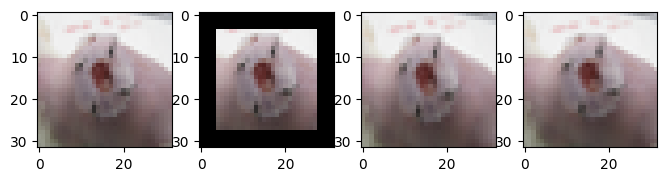

In [180]:
visualize_image_augmentation()

## 4.2 Visualize Model Inference

In [29]:
def visualize(model_dict):
    """
    Visualize the inference result of the model.
    :param model_dict: Dictionary of the four models.
    """
    # Test Data
    Y_inference = get_labels(data_type="Test")
    X_inference = get_images(data_type="Test", image_names=Y_inference[:, 0], flatten=True, resize=True)
    X_inference_noresize = get_images(data_type="Test", image_names=Y_inference[:, 0], flatten=False, resize=False)

    # Randomly nine pics
    # Use 3x3 image grid to demonstrate
    num_images = X_inference.shape[0]
    random_indices = random.sample(range(num_images), 9)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))  

    for i, ax in enumerate(axs.flatten()):
        random_index = random_indices[i]

        # Flattened for inference, Original for visualization
        X_sample = np.array([X_inference[random_index]])
        X_sample_noresize = X_inference_noresize[random_index].copy()

        # Prediction & Ground Truth
        predictions = inference(model_dict=model_dict, X=X_sample)
        truths = {
            "x": Y_inference[random_index, 1],
            "y": Y_inference[random_index, 2],
            "w": Y_inference[random_index, 3],
            "h": Y_inference[random_index, 4],
        }
        
        # Prediction
        ellipse_center_prediction = int(predictions["x"]), int(predictions["y"])
        ellipse_axilen_prediction = int(predictions["w"] / 2), int(predictions["h"] / 2)
        cv2.ellipse(
            img=X_sample_noresize,
            center=list(ellipse_center_prediction),
            axes=list(ellipse_axilen_prediction),
            angle=0,
            startAngle=0,
            endAngle=360,
            color=(255, 0, 0),
            thickness=5,
        )
        cv2.circle(X_sample_noresize, ellipse_center_prediction, radius=5, color=(255, 0, 0), thickness=10)

        # Ground Truth
        ellipse_center_truth = int(truths["x"]), int(truths["y"])
        ellipse_axilen_truth = int(truths["w"] / 2), int(truths["h"] / 2)
        cv2.ellipse(
            img=X_sample_noresize,
            center=list(ellipse_center_truth),
            axes=list(ellipse_axilen_truth),
            angle=0,
            startAngle=0,
            endAngle=360,
            color=(0, 255, 0),
            thickness=5,
        )
        cv2.circle(X_sample_noresize, ellipse_center_truth, radius=5, color=(0, 255, 0), thickness=10)

        # Plot
        # Also, show prediction values & legend.
        description = (
            f"Image: {random_index + 1}/{num_images}\n"
            f"Pre: x={predictions["x"]:.1f}, y={predictions["y"]:.1f}, "
            f"w={predictions["w"]:.1f}, h={predictions["h"]:.1f}\n"
            f"Tru: x={truths["x"]:.1f}, y={truths["y"]:.1f}, "
            f"w={truths["w"]:.1f}, h={truths["h"]:.1f}"
        )
        ax.set_title(description, fontsize=10, color="black", loc="center")

        fig.legend(handles=[mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Prediction'),
                            mlines.Line2D([], [], color='green', linestyle='-', linewidth=2, label='Ground Truth')], 
                   loc='upper center', 
                   ncol=2, fontsize=12, frameon=True)
        
        ax.imshow(X_sample_noresize)
        # ax.set_title(f"Image: {random_index + 1}/{num_images}")

    plt.tight_layout()
    # plt.subplots_adjust(top=0.9)
    plt.show()


In [30]:
with open(os.path.join(model_path, "best_model_rfr_1733156550837645.sav"), "rb") as best_model_rfr_f:
    best_model_rfr_loaded = pickle.load(best_model_rfr_f)

with open(os.path.join(model_path, "best_model_svr_1733156169715915.sav"), "rb") as best_model_svr_f:
    best_model_svr_loaded = pickle.load(best_model_svr_f)

In [31]:
best_model_rfr_loaded

{'x': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=8,
                       n_estimators=30),
 'y': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=8,
                       n_estimators=30),
 'w': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=8,
                       n_estimators=30),
 'h': RandomForestRegressor(max_depth=19, min_samples_leaf=6, min_samples_split=8,
                       n_estimators=30)}

In [32]:
best_model_svr_loaded

{'x': SVR(C=100, epsilon=1),
 'y': SVR(C=100, epsilon=1),
 'w': SVR(C=100, epsilon=1),
 'h': SVR(C=100, epsilon=1)}

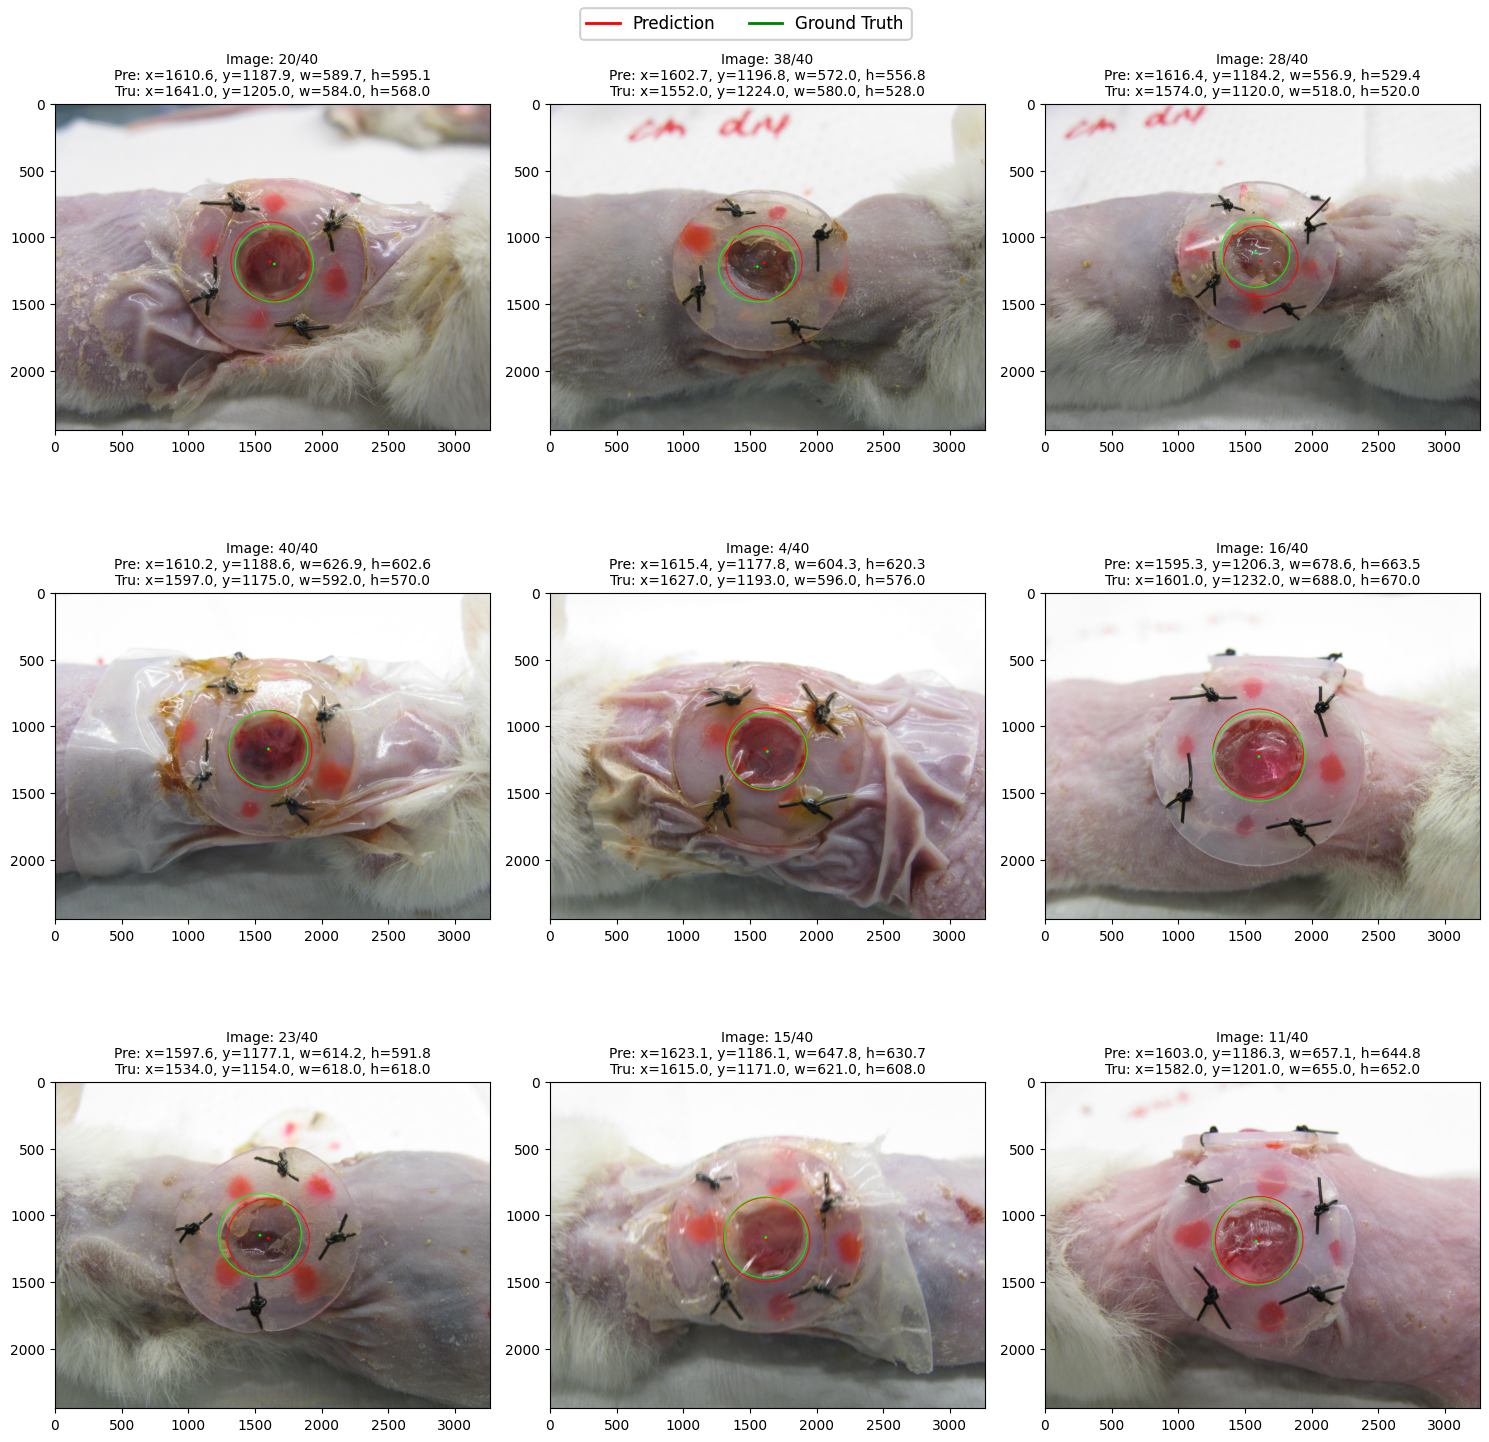

In [33]:
visualize(best_model_rfr_loaded)

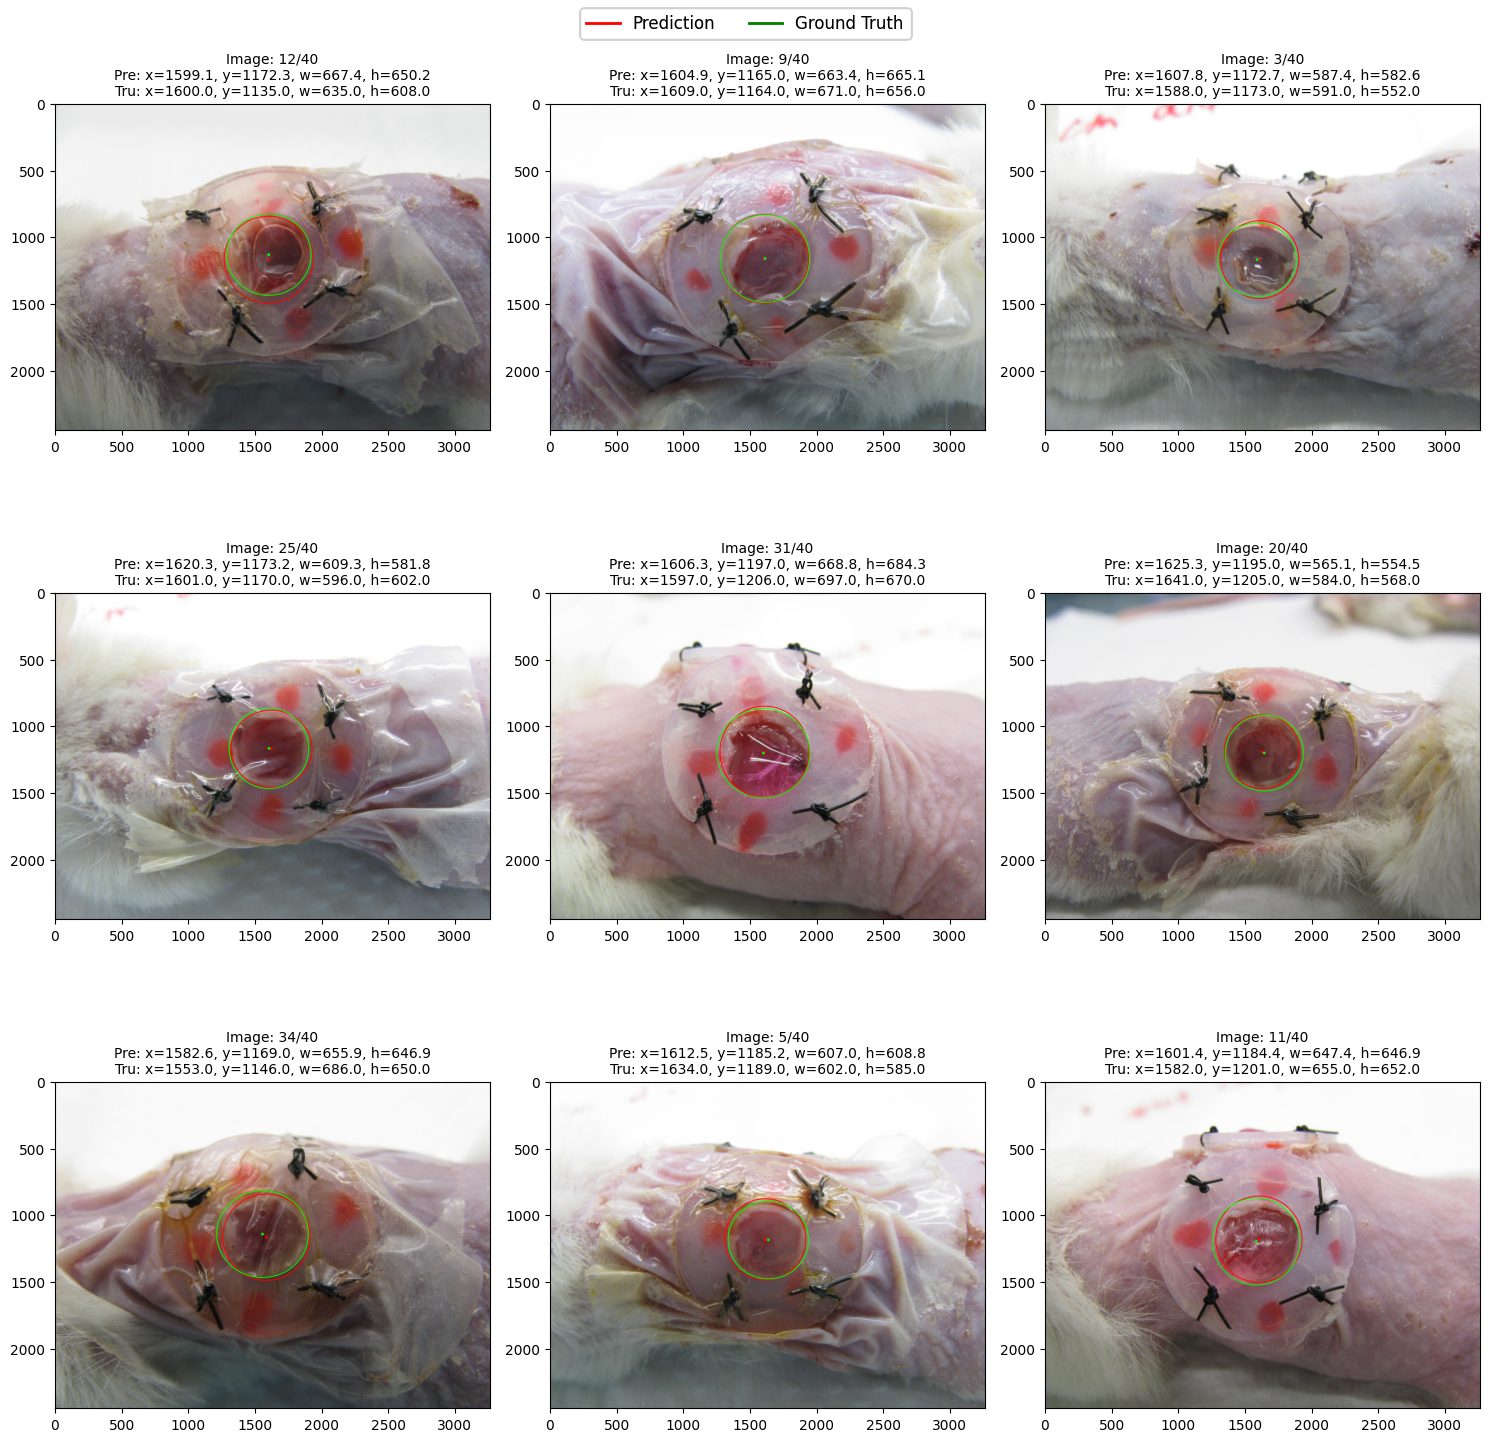

In [34]:
visualize(best_model_svr_loaded)